# Roman-Cuts

A short tutorial on how to use `RomanCuts` to get cutouts from simulated images created with `RImTimSim` [Link](https://github.com/robertfwilson/rimtimsim).

In [80]:
import os
import numpy as np
from glob import glob
from roman_cuts import RomanCuts
import matplotlib.pyplot as plt

In [53]:
PATH = "/Users/jimartin/Work/ROMAN/TRExS/simulations/dryrun_01"

FILTER = "F146"
SCA = 2
FIELD = 3

In [55]:
# get path for all FITS files in disk
ff = sorted(glob(f"{PATH}/simulated_image_data/rimtimsim_WFI_lvl02_{FILTER}_SCA{SCA:02}_field{FIELD:02}_rampfitted_exposureno_*_sim.fits"))
print(f"There are {len(ff)} frames available in {FILTER}")

There are 3298 frames available in F146


In [56]:
# initialize RomanCuts object
rcube = RomanCuts(field=3, sca=1, filter="F146", file_list=ff)
rcube

Roman WFI Field 3 SCA 1 Filter F146 Frames 3298

In [65]:
# we compute/load the average WCS 
rcube.get_average_wcs()
rcube.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 268.49716192918  -29.204794453871  
CRPIX : 2044.0  2044.0  
PC1_1 PC1_2  : 2.618794948832e-05  1.4574831455687e-05  
PC2_1 PC2_2  : -1.5281148012753e-05  2.5443010446103e-05  
CDELT : 1.0  1.0  
NAXIS : 0  0

In [58]:
# make a cutout using pixel row and column coordinates
# here we skip loading all WCS with `load_all_wcss=False`
# to make run faster
rcube.make_cutout(rowcol=(254, 2925), size=(21, 21), load_all_wcss=False)

Getting 3d data...
100%|███████████████████████████████████████████████████████████████████████████████████| 3298/3298 [00:02<00:00, 1269.40it/s]
Getting 1d arrays data...


Getting metadata


In [61]:
# this is the center of the cutout 
rcube.ra, rcube.dec

(array(268.45823483), array(-29.15501013))

In [62]:
# we have the flux and errors in 3d arrays
rcube.flux.shape, rcube.flux_err.shape

((3298, 21, 21), (3298, 21, 21))

In [63]:
# we have the time, cadence numbe and quality flags
rcube.time.shape, rcube.cadenceno.shape, rcube.quality.shape

((3298,), (3298,), (3298,))

In [64]:
# and the metadata
rcube.metadata

{'MISSION': 'Roman',
 'TELESCOP': 'Roman',
 'CREATOR': 'TRExS',
 'SOFTWARE': 'rimtimsim_v2.0',
 'RADESYS': 'FK5',
 'EQUINOX': 2000.0,
 'FILTER': 'F146',
 'FIELD': 3,
 'DETECTOR': 'SCA02',
 'EXPOSURE': 54.72,
 'READMODE': 'rampfitted',
 'RA_CEN': 268.4582348320807,
 'DEC_CEN': -29.155010131364055}

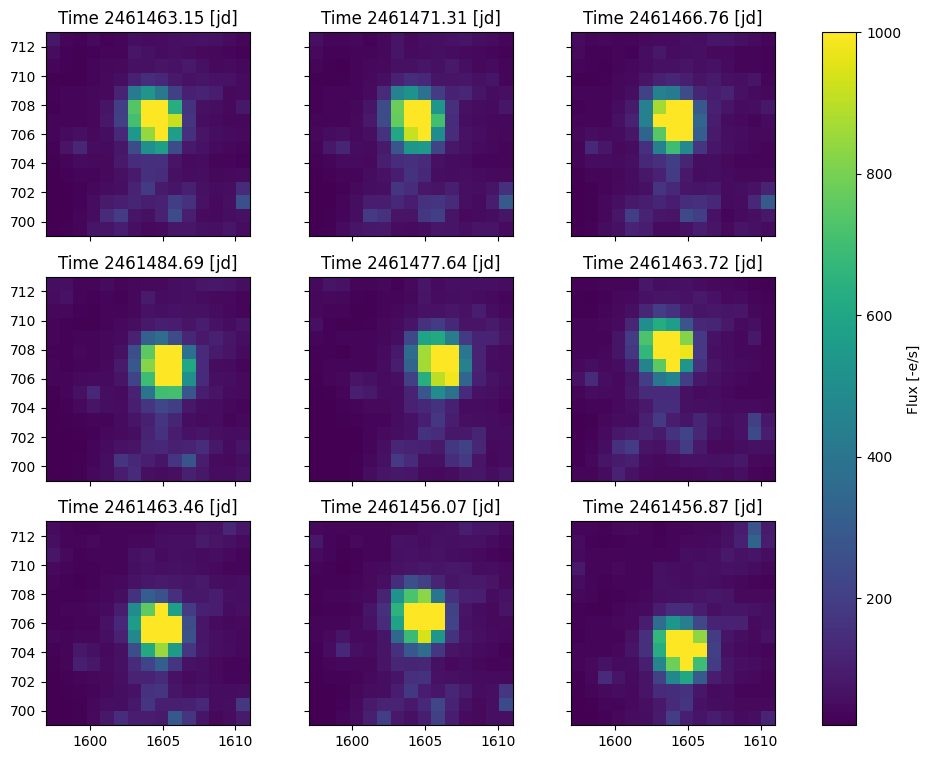

In [99]:
# we can check a few stamps

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(12,9))
tdx = np.random.choice(rcube.cadenceno, size=9, replace=False)
for axis, t in zip(ax.ravel(), tdx):
    bar = axis.imshow(rcube.flux[t], 
                origin="lower", 
                vmin=20, 
                vmax=1000, 
                extent=(rcube.row.min(), rcube.row.max(), rcube.column.min(), rcube.column.max()),
               )
    axis.set_title(f"Time {rcube.time[t]:.2f} [jd]")
plt.colorbar(bar, ax=ax, location="right", label="Flux [-e/s]" )
plt.show()

In [66]:
# we save the cutout to disk as ASDF file 
rcube.save_cutout(output="./test.asdf")

In [67]:
import asdf

In [68]:
af = asdf.open("./test.asdf")

In [75]:
af.info(max_rows=None)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (str): asdf://asdf-format.org/core/extensions/core-1.6.0
│   │ ├─manifest_software (Software)
│   │ │ ├─name (str): asdf_standard
│   │ │ └─version (str): 1.1.1
│   │ └─software (Software)
│   │   ├─name (str): asdf
│   │   └─version (str): 4.1.0
│   └─[1] (ExtensionMetadata)
│     ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│     ├─extension_uri (str): asdf://astropy.org/astropy/extensions/astropy-1.3.0
│     └─software (Software)
│       ├─name (str): asdf-astropy
│       └─version (str): 0.7.1
└─roman (dict)
  ├─data (dict)
  │ ├─cadenceno (NDArrayType)
  │ │ ├─shape (tuple)
  │ │ │ └─[0] (int): 3298
  │ │ └─dtype (In

In [76]:
# we can use sky coordinates to center the cutout
# the target won't be centered becouse of dittering
# the cutouts are with fixed pixel grids.
radec = (268.461687, -29.232092)

In [77]:
# we can request all WCSs, it will take a few seconds more
rcube.make_cutout(radec=radec, size=(15, 15), load_all_wcss=True)

Using Ra, Dec coordinates and average WCS to center the cutout
Getting 3d data...
100%|███████████████████████████████████████████████████████████████████████████████████| 3298/3298 [00:03<00:00, 1069.47it/s]
Getting 1d arrays data...


Getting metadata
Getting WCSs per frame


In [78]:
# we can save the file to disk with default name
rcube.save_cutout()

Saving data to ./roman_cutout_field03_SCA02_268.4617_-29.2321_s15x15.asdf


In [79]:
# this one contains all the WCS per frame in the ASDF
af = asdf.open("./roman_cutout_field03_SCA02_268.4617_-29.2321_s15x15.asdf")
af.info(max_rows=None)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (str): asdf://asdf-format.org/core/extensions/core-1.6.0
│   │ ├─manifest_software (Software)
│   │ │ ├─name (str): asdf_standard
│   │ │ └─version (str): 1.1.1
│   │ └─software (Software)
│   │   ├─name (str): asdf
│   │   └─version (str): 4.1.0
│   └─[1] (ExtensionMetadata)
│     ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│     ├─extension_uri (str): asdf://astropy.org/astropy/extensions/astropy-1.3.0
│     └─software (Software)
│       ├─name (str): asdf-astropy
│       └─version (str): 0.7.1
└─roman (dict)
  ├─data (dict)
  │ ├─cadenceno (NDArrayType)
  │ │ ├─shape (tuple)
  │ │ │ └─[0] (int): 3298
  │ │ └─dtype (In